# Bike lanes and hierarchical modeling

In [1]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, matplotlib.pyplot as plt, theano.tensor as tt
from scipy import stats

In [2]:
# Data from Table 3.3 in BDA
bicycles = np.array([16,9,10,13,19,20,18,17,35,55])
others = np.array([58,90,48,57,103,57,86,112,273,64])

df = pd.DataFrame(data = np.column_stack((bicycles, others)), columns = ['bicycles', 'others'] )
df['total'] = df['bicycles'] + df['others']
df

,bicycles,others,total
0,16,58,74
1,9,90,99
2,10,48,58
3,13,57,70
4,19,103,122
5,20,57,77
6,18,86,104
7,17,112,129
8,35,273,308
9,55,64,119


## Nonhierarchical models

Two nonhierarchical models: 
* a fully pooled model, where we treat each street as a separate observation of a single underlying parameter
* a fully separated model, where we treat each street as an independent quantity with its own parameter

#### Pooled
$$
\begin{align}
y_j &\sim \mathrm{Binomial}(\theta, n_j) \\
\theta &\sim \mathrm{Beta}(\alpha_0, \beta_0)
\end{align}
$$

where $y_j$ is the number of bicycles, and $n_j$ the number of total vehicles observed on each street. Then, the posterior distribution is

$$
\theta | y_j \sim \mathrm{Beta}(\alpha_0 + \sum_j y_j, \beta_0 + \sum_j (n_j - y_j) )
$$

#### Separated
$$
\begin{align}
y_j &\sim \mathrm{Binomial}(\theta_j, n_j) \\
\theta_j &\sim \mathrm{Beta}(\alpha_0, \beta_0)
\end{align}
$$

where $y_j$ is the number of bicycles, and $n_j$ the number of total vehicles observed on each street. Then, the posterior distribution is

$$
\theta_j | y_j \sim \mathrm{Beta}(\alpha_0 + y_j, \beta_0 + (n_j - y_j) )
$$

In [3]:
a0, b0 = 1, 3

### Pooled model

pooled_posterior = sp.stats.beta(a0 + df['bicycles'].sum(), b0 + df['others'].sum())

### Separated model

separated_posteriors = [sp.stats.beta(a0 + df.loc[i, 'bicycles'], b0 + df.loc[i, 'others']) for i in range(len(df))]
len(separated_posteriors)

10

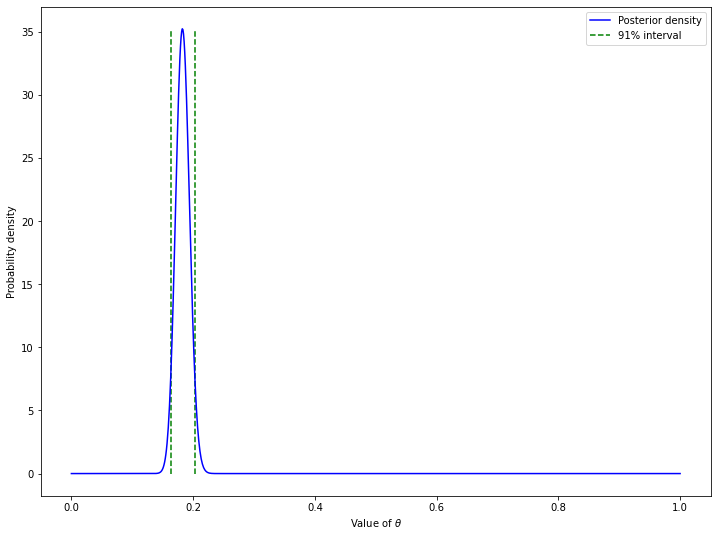

In [4]:
grid = np.linspace(0, 1, 1000)
ymax = pooled_posterior.pdf(pooled_posterior.mean())

plt.figure(figsize = (12, 9))
plt.plot(grid, pooled_posterior.pdf(grid), 'b-', label = 'Posterior density')
plt.vlines(x=(pooled_posterior.ppf(0.045), pooled_posterior.ppf(0.955)), ymin=0, ymax=ymax, color='g', linestyle='--', label = '91% interval')
plt.xlabel('Value of $\\theta$')
plt.ylabel('Probability density')
plt.legend()
plt.show()

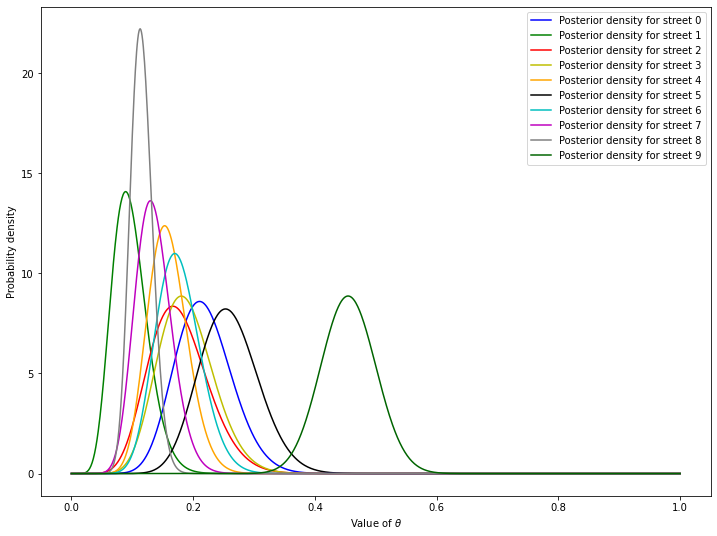

In [5]:
colors = ['b','g','r','y','orange','k','c','m','gray', 'darkgreen']

plt.figure(figsize = (12, 9))
for i in range(len(separated_posteriors)):
    plt.plot(grid, separated_posteriors[i].pdf(grid), label = 'Posterior density for street ' + str(i), color = colors[i])
plt.xlabel('Value of $\\theta$')
plt.ylabel('Probability density')
plt.legend()
plt.show()

In [6]:
[(separated_posteriors[i].ppf(0.045), separated_posteriors[i].ppf(0.955)) for i in range(10)]

[(0.14392524348329852, 0.3010483470747747),
 (0.05314173628522766, 0.15080910232834777),
 (0.1027430422394885, 0.2651555450144615),
 (0.11805502487281376, 0.27086221261290966),
 (0.10730734789867986, 0.2169351082644354),
 (0.1810565254809191, 0.344924445017855),
 (0.11802764844619647, 0.24134277651038794),
 (0.08885192718173247, 0.1886864008856033),
 (0.08637152161751416, 0.14747969840787833),
 (0.3799053114016065, 0.5315756759686823)]

## Hierarchical model

The nonhierarchical models of the previous section lead us to a forced dichotomy: either we estimate a single $\theta$, or we estimate $J$ completely independent $\theta_j$s. But neither of these approaches are fully satisfactory:
* It is likely that different streets are in fact different, so we shouldn't expect them all to be equivalent, and pooling the observations to estimate a single $\theta$ doesn't yield the right estimate.
* On the other hand, it is unreasonable to transfer no information from one observation to another. Streets in the same neighborhood likely obey at least somewhat similar patterns of use.

The Bayesian approach allows us a compromise: so-called "partial pooling" with a hierarchical (aka multi-level) model. In a hierarchical model, we consider each of the $\theta_j$s to be independently drawn from a distribution $p(\theta | \phi)$, conditional on so-called *hyperparameters* $\phi$, which we estimate along with the $\theta_j$s. This can be rendered as a DAG -- in many cases, a tree -- with the hyperparameters at the top, and parameters below it. (There is no need for a limitation on the number of levels in the model, but the simplest versions, which we'll start with, have only two levels.)

We'll stick with a binomial likelihood and with beta distributions for the $\theta_j$, but instead of using a fixed prior beta distribution, we take the priors for $\theta_j$ to be $\mathrm{Beta}(\alpha, \beta)$, with $\alpha, \beta$ themselves drawn from a *hyperprior* distribution $p(\alpha, \beta)$.

Our model is now:
$$
\begin{align}
y_j &\sim \mathrm{Binomial}(\theta_j, n_j) \\
\theta_j &\sim \mathrm{Beta}(\alpha, \beta) \\
\alpha &:= \eta \mu \\
\beta &:= \eta(1-\mu) \\
\mu &\sim \mathrm{Beta}(1, 3) \\
\eta &\sim \mathrm{HalfCauchy}(1)
\end{align}
$$

Here, $\mu, \eta$ are location and scale parameters for the distribution from which $\theta_j$ are drawn. We assign weakly informative priors to these and derive $\alpha, \beta$ from them. Notice we don't have to explicitly specify priors for $\alpha$ and $\beta$ (but we could -- see below).


### Building the model in PyMC3

In [7]:
with pm.Model() as hierarchical_model:
    # Weakly informative prior for alpha and beta
    mu = pm.Beta('mu', 1, 3)
    eta = pm.HalfCauchy('eta', 1)
    
    alpha = pm.Deterministic('alpha', eta * mu)
    beta = pm.Deterministic('beta', eta * (1 - mu))
    
    # Distributions for theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape = 10) # shape = 10 makes a vector of 10 parameters
    
    # Data distribution
    y_obs = pm.Binomial('y_obs', p = theta, observed = df.bicycles, n=df.total)
    
    # Inference
    trace = pm.sample(4000, target_accept = 0.8, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, eta, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1582.09draws/s]


In [8]:
summary = pm.summary(trace)
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.208,0.039,0.139,0.282,0.000,0.000,8202.0,7347.0,9047.0,5749.0,1.0
eta,15.974,9.582,2.570,32.982,0.124,0.097,6001.0,4907.0,6976.0,5554.0,1.0
alpha,3.219,1.839,0.626,6.517,0.024,0.018,5982.0,4992.0,6999.0,5411.0,1.0
beta,12.755,7.832,1.831,26.522,0.101,0.079,6029.0,4892.0,6975.0,5514.0,1.0
theta[0],0.214,0.043,0.135,0.297,0.000,0.000,11449.0,11011.0,11337.0,6255.0,1.0
theta[1],0.106,0.030,0.054,0.164,0.000,0.000,10664.0,9874.0,10559.0,6002.0,1.0
theta[2],0.179,0.045,0.095,0.263,0.000,0.000,11988.0,11130.0,11927.0,5879.0,1.0
theta[3],0.189,0.041,0.115,0.266,0.000,0.000,11850.0,11608.0,11609.0,5604.0,1.0
theta[4],0.161,0.031,0.103,0.218,0.000,0.000,11766.0,11423.0,11567.0,5631.0,1.0
theta[5],0.250,0.045,0.169,0.338,0.000,0.000,12451.0,12088.0,12268.0,6039.0,1.0


### Two useful visualizations:

* Forest plot: lets us compare the individual streets
* Posterior plot: we've seen this before, but it's most useful for examining the hyperparameters here

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'eta'}>], dtype=object)

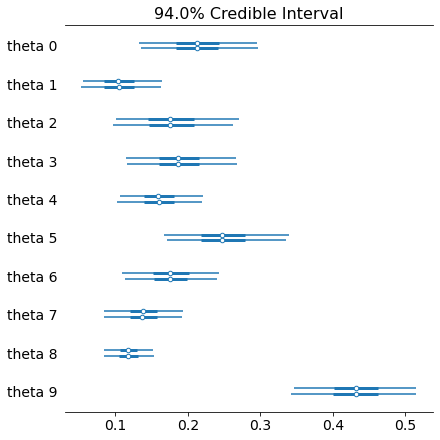

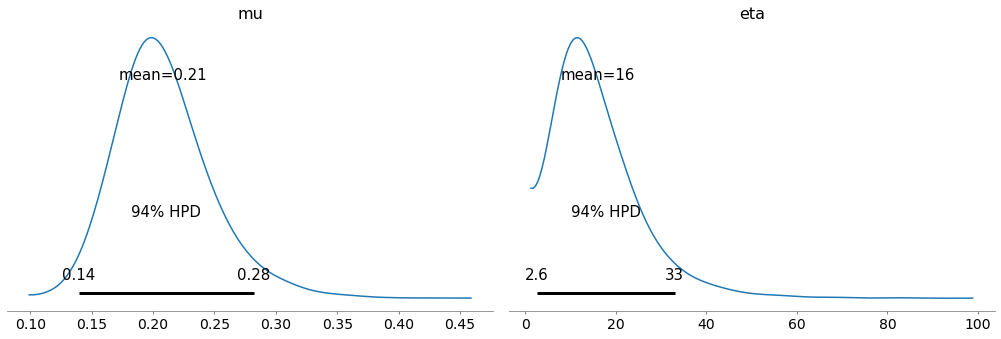

In [9]:
pm.forestplot(trace, var_names = ['theta'])
pm.plot_posterior(trace, var_names = ['mu', 'eta'])

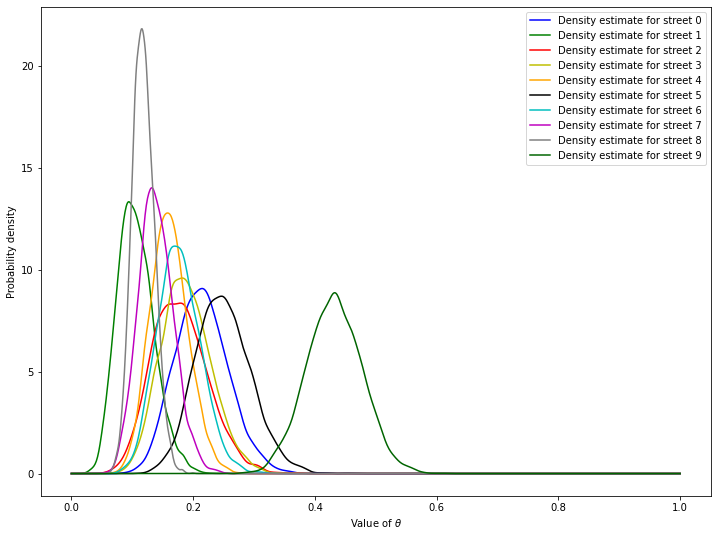

In [10]:
plt.figure(figsize = (12, 9))
for i in range(10):
    kernel = sp.stats.gaussian_kde(trace['theta'][:, i])
    plt.plot(grid, kernel(grid), label = 'Density estimate for street ' + str(i), color = colors[i])
    #plt.plot(grid, separated_posteriors[i].pdf(grid), label = 'Posterior density for street ' + str(i))
plt.xlabel('Value of $\\theta$')
plt.ylabel('Probability density')
plt.legend()
plt.show()

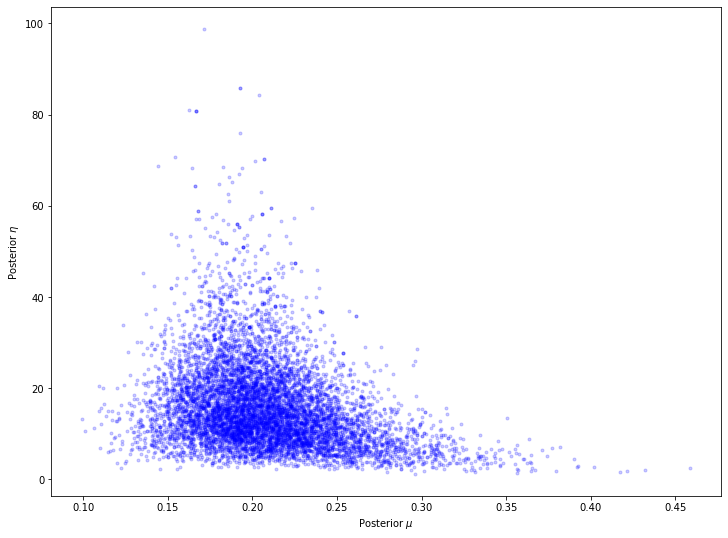

In [11]:
plt.figure(figsize=(12, 9))
plt.plot(trace['mu'], trace['eta'], 'b.', alpha = 0.2)
plt.xlabel('Posterior $\\mu$')
plt.ylabel('Posterior $\\eta$')
plt.show()

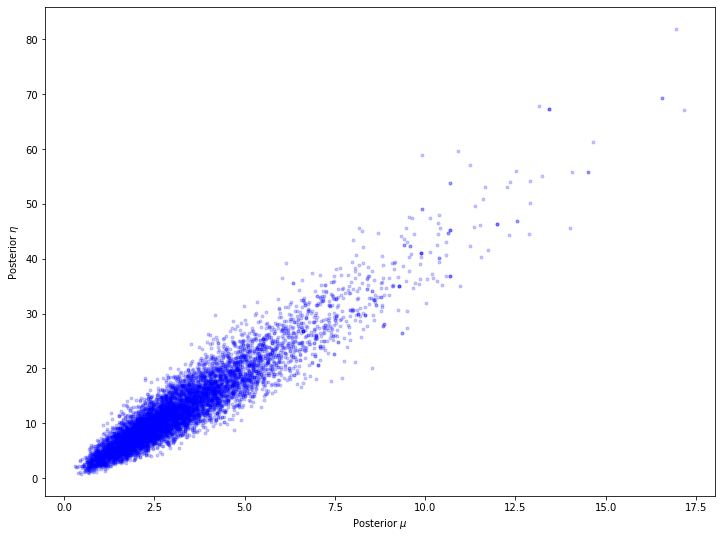

In [12]:
plt.figure(figsize=(12, 9))
plt.plot(trace['alpha'], trace['beta'], 'b.', alpha = 0.2)
plt.xlabel('Posterior $\\mu$')
plt.ylabel('Posterior $\\eta$')
plt.show()

## A comparison

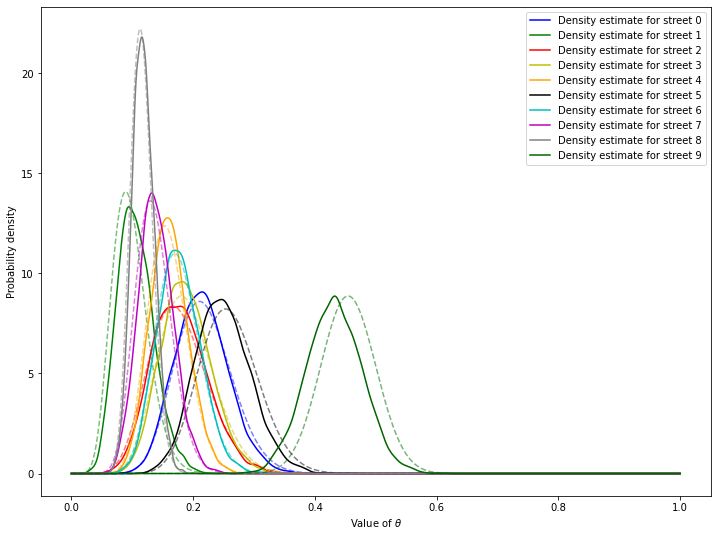

In [13]:
plt.figure(figsize = (12, 9))
for i in range(10):
    kernel = sp.stats.gaussian_kde(trace['theta'][:, i])
    plt.plot(grid, kernel(grid), label = 'Density estimate for street ' + str(i), color = colors[i])
    plt.plot(grid, separated_posteriors[i].pdf(grid), linestyle='--', color = colors[i], alpha = 0.5)
plt.xlabel('Value of $\\theta$')
plt.ylabel('Probability density')
plt.legend()
plt.show()

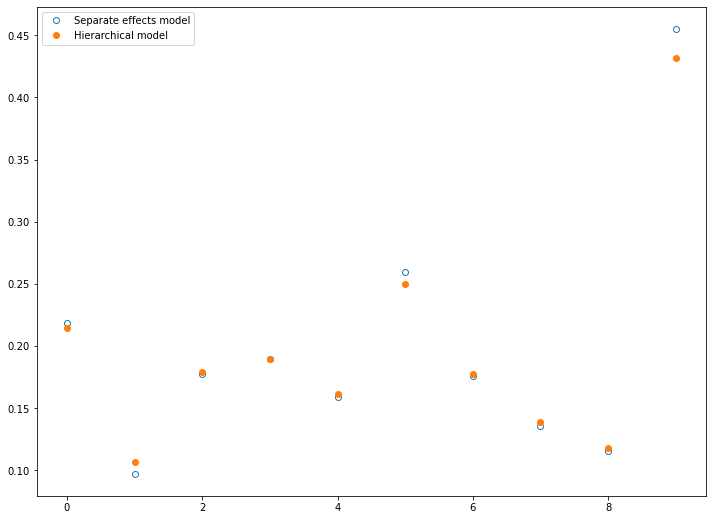

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(range(10), [separated_posteriors[i].mean() for i in range(10)], 'o', mfc='none', label = 'Separate effects model')
plt.plot(range(10), summary[4:]['mean'], 'o', label = 'Hierarchical model')
plt.legend()
plt.show()

### Exercise

Suppose we go back to street 5 and count vehicles until we've observed 100 total. Simulate 1000 runs from the predictive distribution for the number of bicycles, and find a 90% interval for this count. *(Hint: take 1000 samples from the trace for that street's theta parameter, and use them to generate binomial counts for 100 trials.)*

In [15]:
thetas = trace['theta'][:1000,5]
counts = sp.stats.binom.rvs(100, thetas)
(np.quantile(counts, 0.05), np.quantile(counts, 0.95))

(15.0, 36.0)

### Exercise

Suppose we select a new street from a similar "population" of streets and count vehicles until we've observed 100 total. Simulate 1000 runs from the predictive distribution for the number of bicycles, and find a 90% interval for this count. *(Hint: take 1000 samples from the trace for alpha and beta; use those to generate 1000 thetas; then, generate binomial counts.)*

### The prior from BDA3

In [30]:
def logp_ab(value):
    '''Transformation for the hyperprior. Theano tensor magic.'''
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as hierarchical_model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))
    
    M = pm.Deterministic('M', ab[0] / tt.sum(ab))

    # Distributions for theta
    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape = 10)
    
    # Data distribution
    y_obs = pm.Binomial('y_obs', p = theta, observed = df.bicycles, n=df.total)
    
    trace = pm.sample(4000, target_accept = 0.8, tune = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, ab]
Sampling 2 chains, 13 divergences: 100%|██████████| 12000/12000 [00:15<00:00, 775.38draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8822054848773825, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab[0],3.610,1.999,0.701,7.194,0.038,0.031,2728.0,2115.0,3254.0,3921.0,1.0
ab[1],14.254,8.518,1.665,29.261,0.162,0.135,2772.0,1993.0,3313.0,3845.0,1.0
M,0.209,0.039,0.140,0.281,0.000,0.000,8092.0,7367.0,8477.0,5724.0,1.0
theta[0],0.213,0.043,0.136,0.294,0.000,0.000,12300.0,12152.0,11906.0,5165.0,1.0
theta[1],0.107,0.029,0.055,0.162,0.000,0.000,10824.0,9671.0,10839.0,5846.0,1.0
theta[2],0.179,0.044,0.099,0.263,0.000,0.000,11935.0,11095.0,11764.0,5814.0,1.0
theta[3],0.189,0.042,0.110,0.266,0.000,0.000,11924.0,11322.0,11721.0,5659.0,1.0
theta[4],0.161,0.031,0.105,0.220,0.000,0.000,11695.0,11105.0,11609.0,6219.0,1.0
theta[5],0.250,0.045,0.165,0.333,0.000,0.000,10954.0,10444.0,10922.0,5932.0,1.0
theta[6],0.177,0.035,0.115,0.245,0.000,0.000,10831.0,10831.0,10635.0,6080.0,1.0


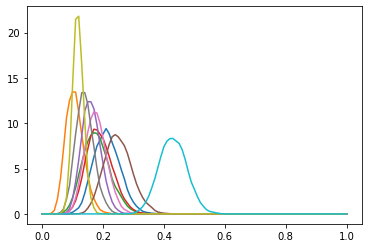

In [18]:
for i in range(10):
    kernel = sp.stats.gaussian_kde(trace['theta'][:, i])
    grid = np.arange(0, 1.01, .01)
    plt.plot(grid, kernel(grid))
plt.show()

### The hard way

The "hard way" to do inference on this model is to explicitly compute the posterior density for $\alpha, \beta$ and use it to sample from the joint posterior distribution of $(\alpha, \beta, \theta_1, \ldots, \theta_{10})$. We go through this exercise for the sake of completeness.

#### Step 1: calculate the posterior density for $\alpha$, $\beta$

A formula for the posterior density $p(\alpha, \beta | y)$ for a similar example can be found in section 5.3 of the book:

$$ p(\alpha, \beta | y) = p(\alpha, \beta) \prod_{j=1}^J \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)}{\Gamma(\alpha + \beta + n_j)} $$

This allows us to compute $p(\alpha, \beta | y)$ on a grid of $\alpha, \beta$ values.

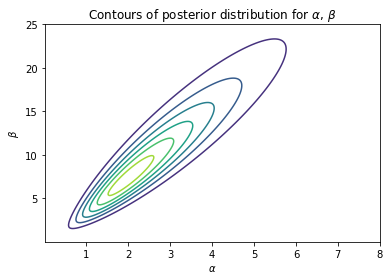

In [19]:
'''
Compute the un-normalized posterior density for alpha and beta and plot contours.
'''

from scipy.special import gammaln # log of the gamma function

# Work in logs to prevent underflows.
# The posterior density can be found in section 5.3 of BDA (equation 5.8)
def logposterior(a, b, data):
    post = (-5/2) * np.log(a + b)
    for j in range(len(data)):
        post += gammaln(a + b) - gammaln(a) - gammaln(b)
        post += gammaln(a + data.bicycles[j]) + gammaln(b + data.others[j]) - gammaln(a + b + data.bicycles[j] + data.others[j])
    return post

alphagrid = np.linspace(0.01, 8, 500)
betagrid = np.linspace(0.01, 25, 500)

X, Y = np.meshgrid(alphagrid, betagrid)
Z = logposterior(X, Y, df)
Z -= np.max(Z)
Z = np.exp(Z)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
#ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Contours of posterior distribution for $\\alpha$, $\\beta$')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')
plt.show()

In [20]:
# Now let's calculate a normalized posterior density

alphagrid = np.arange(0.01, 20.01, 0.02)
betagrid = np.arange(0.01, 40.01, 0.02)
X, Y = np.meshgrid(alphagrid, betagrid)
Z = logposterior(X, Y, df)
Z -= np.max(Z)
Z = np.exp(Z)
normconst = np.sum(Z) * (0.02 ** 2) # Don't forget to scale by the grid size!
Z /= normconst

Now that we have a joint PDF for $\alpha, \beta$, we can use this to sample from the posterior by the following approach:
1. Find the marginal density of $\alpha$ by summing the joint PDF over $\beta$.
2. Draw samples of $\alpha$ from this marginal density.
3. For each sample value of $\alpha$, get the conditional density of $\beta$ by taking a slice from the joint PDF, and use this to draw a sample value of $\beta$.
4. For each sampled pair $(\alpha_i, \beta_i)$, draw a vector of $\theta_j$s from their posterior distribution $\theta_j \sim \mathrm{Beta}(\alpha_i + y_j, \beta_i + n_j - y_j)$.

Then we can examine our sampled $\theta_j$s to make inferences.

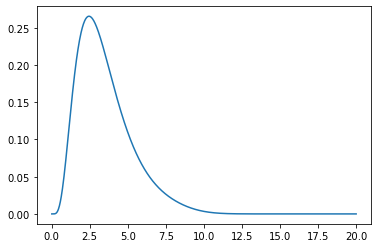

In [21]:
# Marginal posterior of alpha

margina = np.sum(Z, 0)
margina /= np.sum(margina * 0.02)
plt.plot(alphagrid, margina)

To sample from this distribution, we use the inverse-CDF method. Recall the CDF of a random variable is the function $F(x) = \mathrm{Pr}(X \leq x)$. If we know the inverse CDF $F^{-1}(p)$, we can feed it values uniformly drawn from $[0, 1]$ and obtain samples from the distribution of $X$. Below, we define a simple function to implement the inverse CDF method.

In [22]:
# Having estimated the pdf of alpha, we can draw samples from this distribution by the inverse-cdf method

def inverse_cdf(p, grid, pdf_array):
    '''
    Computes the inverse CDF of a probability given an estimated PDF evaluated on a grid.
    Parameters:    
    '''
    spacing = grid[1] - grid[0]
    totp = 0
    for i in range(len(grid)):
        if p < totp:
            return grid[i]
        totp += pdf_array[i] * spacing
    return grid[-1]

alpha_sample = []
for i in range(2000):
    x = np.random.rand()
    alpha_sample.append(inverse_cdf(x, alphagrid, margina))
alpha_sample = np.array(alpha_sample)
np.average(alpha_sample)

3.5411099999999993

In [23]:
beta_sample = []
for alpha in alpha_sample:
    idx = np.where(alphagrid == alpha)
    marginb = Z[:, idx[0][0]]
    marginb /= np.sum(marginb) * 0.02
    x = np.random.rand()
    beta_sample.append(inverse_cdf(x, betagrid, marginb))
beta_sample = np.array(beta_sample)
np.average(beta_sample)

13.978639999999997

In [24]:
# Finally we can sample some thetas
theta = np.zeros((2000, 10))
for i in range(2000):
    for j in range(10):
        theta[i,j] = sp.stats.beta.rvs(alpha_sample[i] + df.bicycles[j], beta_sample[i] + df.others[j])

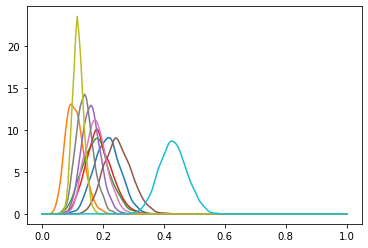

array([0.21409749, 0.1069264 , 0.17850183, 0.18703585, 0.16146789,
       0.24907465, 0.17688038, 0.14036862, 0.11820924, 0.42962445])

In [25]:
# Plot all the posteriors for thetas
for i in range(10):
    kernel = sp.stats.gaussian_kde(theta[:, i])
    grid = np.arange(0, 1.005, .005)
    plt.plot(grid, kernel(grid))
plt.show()

# Posterior means
np.average(theta, 0)